# Plots for Observation Plans at I-LOFAR and LOFAR-SE 
Code used to find suitable targets for observation at a given station. In this case it is used for I-LOFAR and LOFAR-SE stations to find suitable canidates for dual observations from the T.E.S.S exo-planet catalog. This script will work with any station or telescope with slight modification. 

### Parameter Setup 

In [2]:
# --- Preamble --- 

import numpy as np
import pandas as pd
import astropy
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun, get_moon #- for tranformations, takes ref. from simbad.
from astropy.time import Time
import datetime
from datetime import time
from astroplan import Observer
from datetime import timedelta
from pytz import timezone # timezone information 
import matplotlib.pyplot as plt


#--- plot parameters --- 
plt.rcParams["figure.figsize"] = (15,10)
plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
hfont = {'fontname':'Helvetica'}

# --- Colorblind Safe Pallete --- 

colorblind = ['#648fff',
'#785ef0',
'#dc267f',
'#fe6100',
'#ffb000'] 

In [3]:
# --- Station Parameter's --- 

ILOFAR = Observer(name = 'I-LOFAR',
               location = EarthLocation(lat = 53.09472*u.deg, lon = -7.921667*u.deg, height = 46*u.m),
               timezone = timezone('Europe/Dublin'),
               description = "I-LOFAR Station in Birr, Co. Offaly, Ireland")

ONSULA = Observer(name = 'LOFAR-SE',
               location = EarthLocation(lat = 57.3930555556*u.deg, lon = 11.9177777778*u.deg, height = 20*u.m),
               timezone = timezone('Europe/Stockholm'),
               description = "LOFAR-SE Station in Onsula, Sweden")

### Target Filtering 

At this part of the process the targets from a given list co-ordinates are calculated over an observation span and cross-referenced with both stations to ensure that dual observations can take place. 

In [4]:

# --- Data Config --- 

data_main = pd.read_csv('data/Simultaneous_SETI_TESS_targets_170621.csv') # - loading data from .csv location and printing head

filtered_ILOFAR = data_main[data_main['DEC'] > -7] ; filtered_Onsula = data_main[data_main['DEC'] > -3] 
common_targets = filtered_ILOFAR.merge(filtered_Onsula, how = 'inner' ,indicator=False)
common_targets = common_targets.sort_values(by = 'DEC', ascending = False)

print('Number of objects that do not meet the criteria of both stations:', len(data_main['Name']) - len(common_targets))
print(common_targets.head())
print('Number of objects avalible for observation:',  len(common_targets))

Number of objects that do not meet the criteria of both stations: 0
             Name         RA        DEC
36   TIC288185138  14.856097  82.952254
502  TIC137500798   8.842334  82.927120
657  TIC159244568  15.145332  82.446925
768  TIC315755496  20.688758  82.435302
282  TIC288631580  18.528346  82.305949
Number of objects avalible for observation: 839


# Definition of Plotting Functions

In [5]:
def setup(timezone, specified_time, timespan, data_csv, observatory, granulation):
    '''
    timezone - Timezone in which observations will be taking place (i.e. Birr = 0)
    specified_time - Desired time of observation. Format: year-month-day hour:min:sec
    timespan - Integer input for the number span of hours wished to be observed
    data_csv - location of .csv path containing RA and DEC values. 
    granulation - How many points to calculate along target transit path. 
    '''

    # --- Time and Position config --- 
    
    time = Time(specified_time) + timezone*u.hour # - adjusting for a given time zone
    print('Observation time is', time)

    timespan = np.linspace(0, timespan, granulation)*u.hour
    TIMES = time + timespan 
    time_frame = AltAz(obstime = TIMES, location = observatory.location)

    # - Sun and Moon Location 
    sun_altazs = get_sun(TIMES).transform_to(time_frame)
    moon_altazs= get_moon(TIMES).transform_to(time_frame)

    # --- Data Config --- 

    data_main = pd.read_csv(data_csv) # - loading data from .csv location and printing head

    # - Filtering Targets 

    filtered_ILOFAR = data_main[data_main['DEC'] > -7] ; filtered_Onsula = data_main[data_main['DEC'] > -3] # - Filtering out unsuitable targets 
    common_targets = filtered_ILOFAR.merge(filtered_Onsula, how = 'inner' ,indicator=False) # - Merging Common entries between both stations
    common_targets = common_targets.sort_values(by = 'DEC', ascending = False); common_targets.to_csv(index=False)

    print('Number of objects that do not meet the criteria of both stations:', len(data_main['Name']) - len(common_targets))
    print(common_targets.head())
    print('Number of objects avalible for observation:',  len(common_targets))

    # - isolating of data for transformation 
    Name = common_targets['Name']
    RA = common_targets['RA']
    DEC = common_targets['DEC']

    coords = []

    for i in range(0, len(Name)):
        indv_coord = SkyCoord(RA[i], DEC[i], frame='icrs', unit='deg')
        coords.append([Name[i], indv_coord])

    return coords, time, timespan, sun_altazs, moon_altazs, data_main

In [6]:
def plot_func(setup_data, target_name, observatory): 
    '''
    setup_data - data array from previous function. 
    target - index in array of desired target. 
    observatory - parameters for desired observatory 
    '''
    # --- Target Config --- 

    desired_target = data_main[data_main['Name'] == target_name]
    target_pos = SkyCoord(desired_target['RA'], desired_target['DEC'], frame='icrs', unit='deg') 

    target_frame = AltAz(obstime = setup_data[1] + setup_data[2], location = observatory.location)
    target_window = target_pos.transform_to(target_frame)
    target_altazs = target_pos.transform_to(target_window)

    # --- Sun, Moon and Target Plot --- 

    plt.plot(setup_data[2], setup_data[3].alt, color='r', label = 'Sun')
    plt.plot(setup_data[2], setup_data[4].alt, color = [0.3]*3, ls='--', label = 'Moon')
    plt.scatter(setup_data[2], target_altazs.alt, c = target_altazs.az, label = target_name, lw=0, s=8,  cmap='viridis')

    plt.fill_between(setup_data[2], 0*u.deg, 90*u.deg, setup_data[3].alt < -0*u.deg, color =' 0.4', zorder = 0, alpha = 0.25) 
    plt.fill_between(setup_data[2], 0*u.deg, 90*u.deg, setup_data[3].alt < -18*u.deg, color='k', zorder = 0)

    plt.colorbar().set_label('Azimuth [deg]')
    # plt.legend(loc='upper left')
    # plt.xticks((np.arange(13)*2-12))
    plt.ylim(0, 90)
    plt.xlabel('Time: %s' % setup_data[1])
    plt.ylabel('Altitude [deg]')
    plt.grid()
    plt.axhline(y = 53)


    # while True: 
    #     try: 
    #         ans = str(input("Do you want to save plot?  "))
    #         if ans == 'yes':
    #             loc = str(input("What is the name folder do you want to save it in?"))
    #             plt.savefig(loc + '/%s.png' % target_name, bbox = 'tight')
    #             break;
    #         else: 
    #             print('No image saved.')
    #             break;
    #     except ValueError: 
    #         print('Invalid')
    #         continue

    plt.show()



In [7]:
def plot_func_az(setup_data, target_name, observatory): 
    '''
    setup_data - data array from previous function. 
    target - index in array of desired target. 
    observatory - parameters for desired observatory 
    '''
    # --- Target Config --- 

    desired_target = data_main[data_main['Name'] == target_name]
    target_pos = SkyCoord(desired_target['RA'], desired_target['DEC'], frame='icrs', unit='deg') 

    target_frame = AltAz(obstime = setup_data[1] + setup_data[2], location = observatory.location)
    target_window = target_pos.transform_to(target_frame)
    target_altazs = target_pos.transform_to(target_window)

    # --- Sun, Moon and Target Plot --- 

    plt.plot(setup_data[2], setup_data[3].az, color='r', label = 'Sun')
    plt.plot(setup_data[2], setup_data[4].az, color = [0.3]*3, ls='--', label = 'Moon')
    plt.scatter(setup_data[2], target_altazs.az, c = target_altazs.alt, label = target_name, lw=0, s=8,  cmap='viridis')

    plt.fill_between(setup_data[2], 0*u.deg, 90*u.deg, setup_data[3].alt < -0*u.deg, color =' 0.4', zorder = 0, alpha = 0.25) 
    plt.fill_between(setup_data[2], 0*u.deg, 90*u.deg, setup_data[3].alt < -18*u.deg, color='k', zorder = 0)

    plt.colorbar().set_label('Altitude [deg]')
    plt.legend(loc='upper left')
    plt.xlabel('Time: %s' % setup_data[1])
    plt.ylabel('Azimuth [deg]')
    plt.grid()
    plt.axhline(y = 53)

    plt.show()

In [8]:
def multi_plot_function(setup_data, target_name, observatory): 
    '''
    setup_data - data array from previous function. 
    target - index in array of desired target. 
    observatory - parameters for desired observatory 
    '''
    # --- Target Config --- 

    t = setup_data[1]
    time_axis = setup_data[2]
    data_main = setup_data[5]
    

    desired_target = data_main[data_main['Name'] == target_name]
    target_pos = SkyCoord(desired_target['RA'], desired_target['DEC'], frame='icrs', unit='deg') 

    target_frame = AltAz(obstime = setup_data[1] + time_axis, location = observatory.location)
    target_window = target_pos.transform_to(target_frame)
    target_altazs = target_pos.transform_to(target_window)

    fig, ax = plt.subplots(2, sharex='col', sharey='row')

    # --- Alt-Plot --- 

    ax[0].plot(time_axis, setup_data[3].alt, color =  colorblind[3], label = 'Sun')
    ax[0].plot(time_axis, setup_data[4].alt, color = [0.3]*3, ls='--', label = 'Moon')
    ax[0].scatter(time_axis, target_altazs.alt, label = 'Target', lw=0, s=8, color = colorblind[2])

    ax[0].fill_between(time_axis, 0*u.deg, 90*u.deg, setup_data[3].alt < -0*u.deg, color =' 0.4', zorder = 0, alpha = 0.25) 
    ax[0].fill_between(time_axis, 0*u.deg, 90*u.deg, setup_data[3].alt < -18*u.deg, color='k', zorder = 0)

    ax[0].grid()
    # ax[0].axhline(y = 53)
    ax[0].set_ylim([0, 90])
    

    # --- Azimuth Plot --- 

    ax[1].plot(time_axis, setup_data[3].az, color=colorblind[3], label = 'Sun')
    ax[1].plot(time_axis, setup_data[4].az, color = [0.3]*3, ls='--', label = 'Moon')
    ax[1].scatter(time_axis, target_altazs.az, lw=0, s=8, color = colorblind[2], label = 'Target')

    ax[1].fill_between(time_axis, 0*u.deg, 90*u.deg, setup_data[3].alt < -0*u.deg, color =' 0.4', zorder = 0, alpha = 0.25) 
    ax[1].fill_between(time_axis, 0*u.deg, 90*u.deg, setup_data[3].alt < -18*u.deg, color='k', zorder = 0)
    ax[1].grid()
    ax[1].set_title('')

    # --- Labels --- 

    plt.setp(ax[1], ylabel='Azimuth [deg]')
    plt.setp(ax[0], ylabel='Altitude [deg]')
    ax[0].set_title('%s at %s' % (target_name, observatory.name))
    
    # plt.legend()

    # ax[1].plot_date(t.plot_date, target_altazs.az)
    plt.gcf().autofmt_xdate()
    plt.show()

In [9]:
def dual_plot(target_name): 
    multi_plot_function(ILOFAR_setup, target_name, ILOFAR)
    multi_plot_function(ONSULA_setup, target_name, ONSULA)

# Setup Execution 

Here is wehre time and observation window for relevant stations are set. 

In [19]:
%%time

ILOFAR_setup = setup(0, '2021-7-08 13:50:00', 1.5, 'data/Simultaneous_SETI_TESS_targets_170621.csv', ILOFAR, 500)
ONSULA_setup = setup(0, '2021-7-08 14:50:00', 1.5, 'data/Simultaneous_SETI_TESS_targets_170621.csv', ONSULA, 500)

Observation time is 2021-07-08 13:50:00.000
Number of objects that do not meet the criteria of both stations: 0
             Name         RA        DEC
36   TIC288185138  14.856097  82.952254
502  TIC137500798   8.842334  82.927120
657  TIC159244568  15.145332  82.446925
768  TIC315755496  20.688758  82.435302
282  TIC288631580  18.528346  82.305949
Number of objects avalible for observation: 839
Observation time is 2021-07-08 14:50:00.000
Number of objects that do not meet the criteria of both stations: 0
             Name         RA        DEC
36   TIC288185138  14.856097  82.952254
502  TIC137500798   8.842334  82.927120
657  TIC159244568  15.145332  82.446925
768  TIC315755496  20.688758  82.435302
282  TIC288631580  18.528346  82.305949
Number of objects avalible for observation: 839
Wall time: 891 ms


## Loading .csv of marked targets with associated values.

Plotting targets of intrest to confirm application for time frame, also writing a .txt file for observation. 

In [11]:
def time_string(hour, mins, secs, dur, sep, obs_N): 
    times = []

    a_time = datetime.time(hour, mins, secs)
    a_datetime = datetime.datetime.combine(datetime.date.today(), a_time)
    times.append(a_time)

    for i in range(0, obs_N - 1):
        new_datetime = a_datetime + timedelta(seconds = dur*60 + sep*60)
        new_time = new_datetime.time()
        a_datetime = new_datetime
        times.append(new_time)
    return times

In [30]:
# --- Writing Target list to a text file --- 

filter_data_from_planner = pd.read_csv('data/target-lists/combined/Combined-Targets-210708.csv')

#--- Targets of Intrest Index --- 
excel_index_start = 2
excel_index_end = 5

observation_duration = '15m'
frequency_range = '110e6:190e6'

target_list = filter_data_from_planner[['Name', 'RA', 'DEC']].copy()
target_list = target_list[excel_index_start - 2: excel_index_end - 1] # - indexing from target list .csv 

target_list['RA'] = np.round(target_list['RA']*15*np.pi/180, 6); target_list['DEC'] = np.round(target_list['DEC']*np.pi/180, 6);  target_list['freqrng'] = frequency_range ; target_list['dur'] = observation_duration; target_list['time'] = time_string(12, 54, 0, 15, 1, len(target_list))

#- rarrange 
target_list = target_list[['Name', 'time', 'RA', 'DEC', 'freqrng', 'dur']]
# target_list = target_list[['time', 'RA', 'DEC', 'freqrng', 'dur']]

print(target_list)
numpy_array = target_list.to_numpy()

           Name      time        RA       DEC      freqrng  dur
0  TIC137500798  12:54:00  2.314918  1.447351  110e6:190e6  15m
1  TIC372757221  13:10:00  2.843022  1.419340  110e6:190e6  15m
2  TIC288132261  13:26:00  3.656191  1.388991  110e6:190e6  15m
3  TIC158002130  13:42:00  3.744703  1.434552  110e6:190e6  15m


In [31]:
date = input('Enter DATE of observation in form of YYMMDD')
np.savetxt("data/target-lists/targets-%s.txt" % date, numpy_array, fmt = "%s")

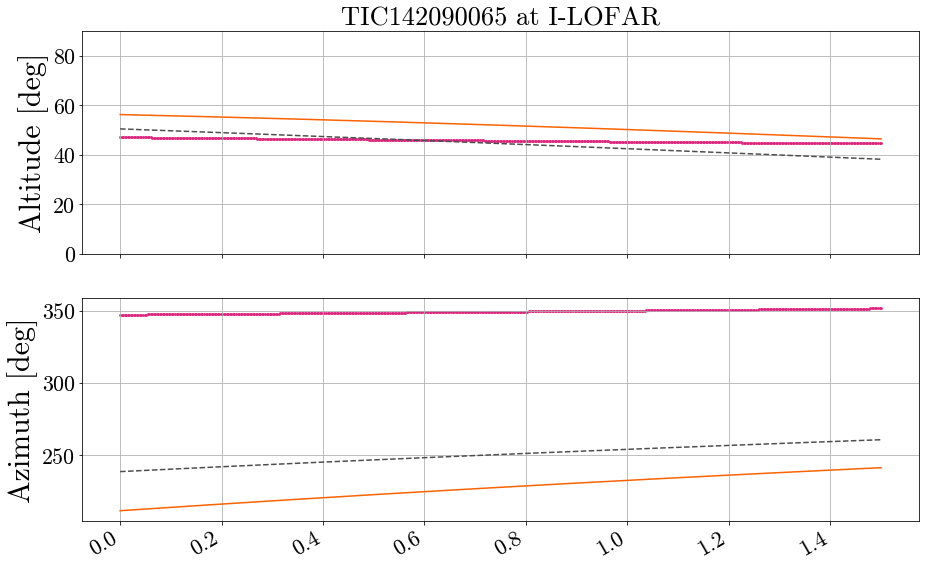

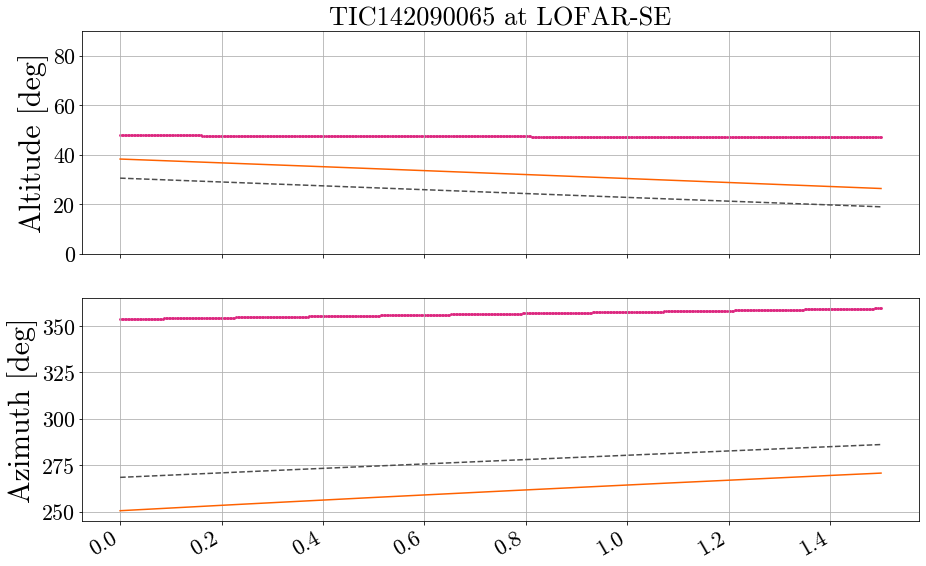

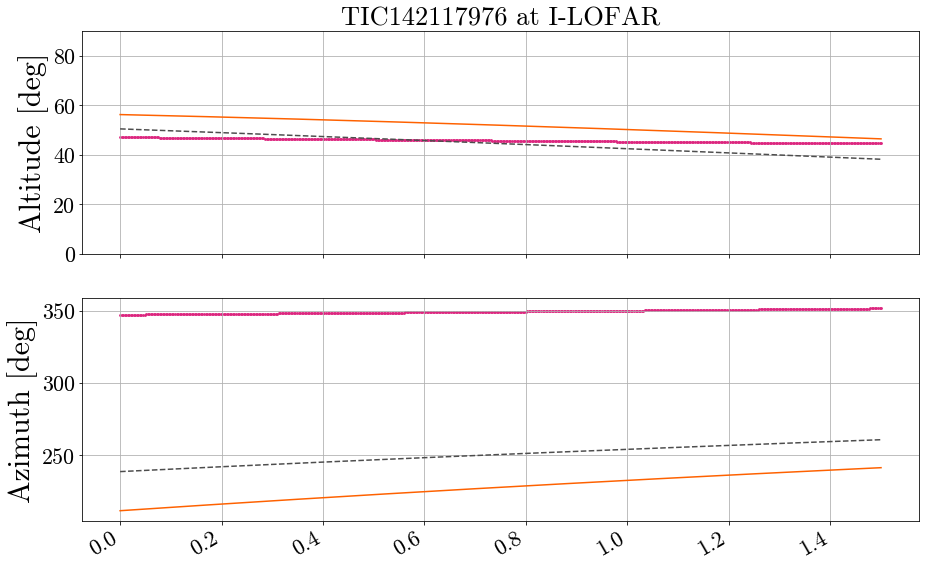

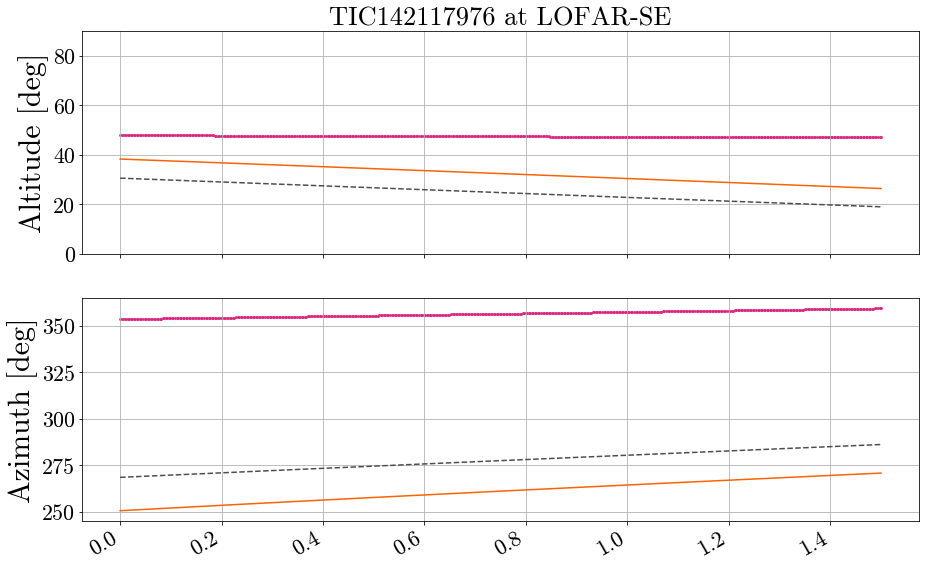

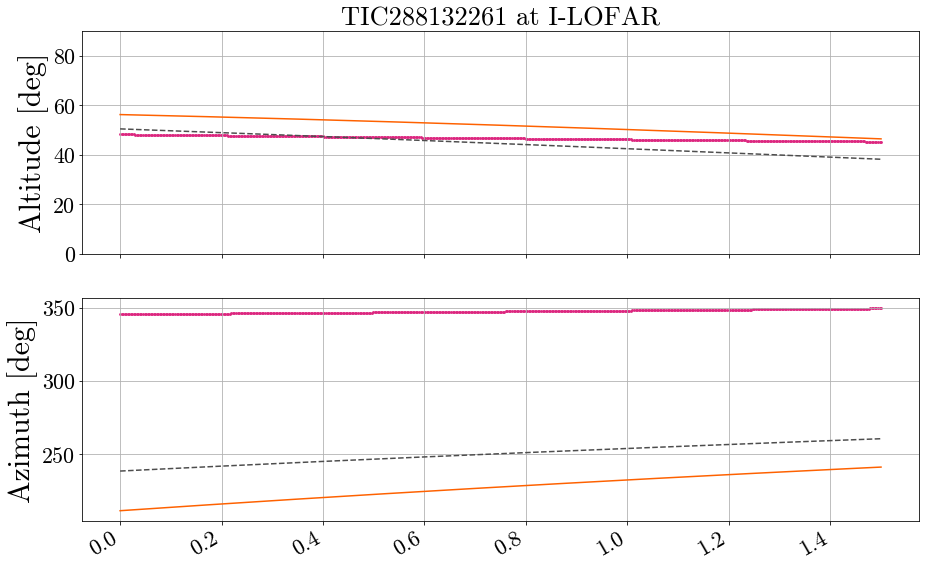

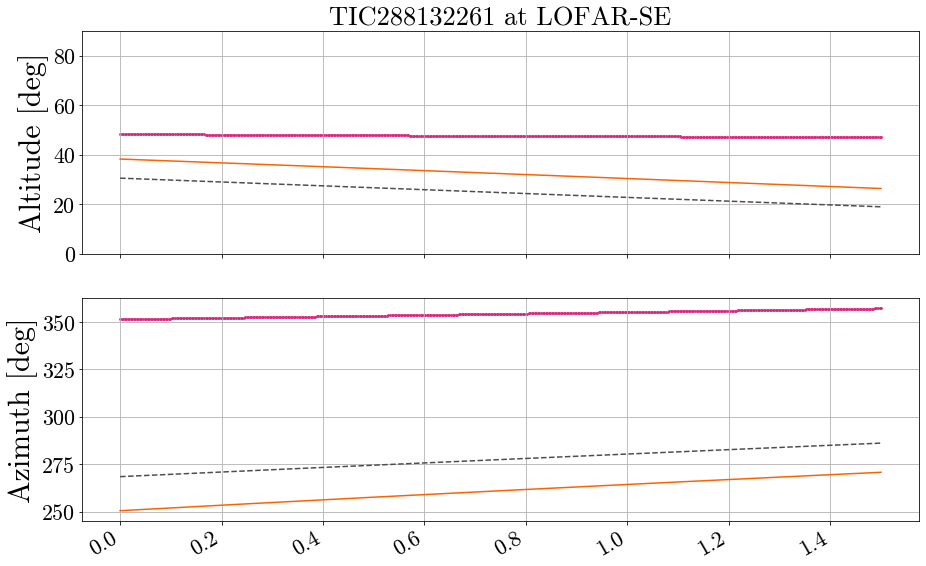

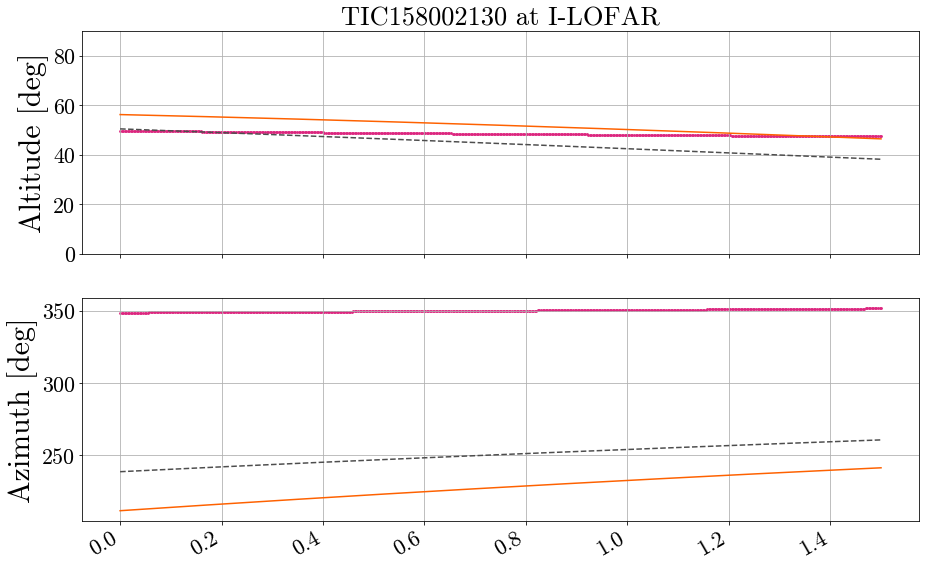

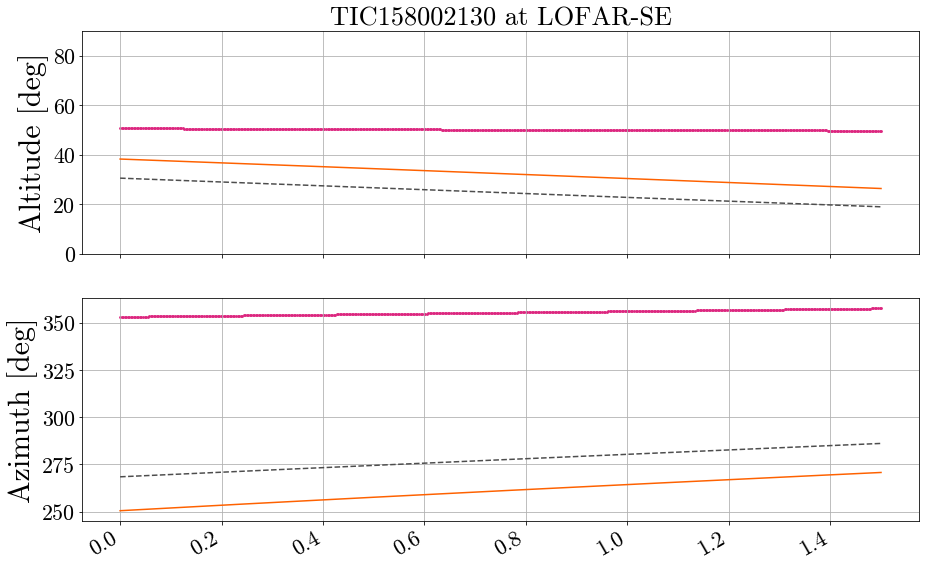

In [20]:
names = filter_data_from_planner['Name'][excel_index_start - 2: excel_index_end - 2].to_numpy()

names = ['TIC142090065',
'TIC142117976',
'TIC288132261',
'TIC158002130']

for i in range(0, len(names)):
    dual_plot(names[i])

# Further Visuals 

Plotting onto a co-ordinate map at various times for further illustration of catalog. 

In [15]:
data_main = pd.read_csv('data/Simultaneous_SETI_TESS_targets_170621.csv') # - loading data from .csv location and printing head
print(data_main.head())

# - isolating of data for transformation 
Name = data_main['Name']
RA = data_main['RA']
DEC = data_main['DEC']

           Name         RA        DEC
0  TIC101929303  19.951591  35.988359
1  TIC122220263  19.334730  36.637772
2   TIC13419950  20.352623  41.462365
3  TIC138361973  19.584332  37.538601
4  TIC142276270  12.812327  64.855277


In [16]:
# fig = plt.figure(figsize=(16, 12), **hfont)
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(RA, DEC)
ax.grid(True)

NameError: name 'fig' is not defined